## Báo cáo Xử lý đa chiều
## Code demo 1: Auto encoder Non-negative matrix factorization

### Nhóm:
#### 1. Nguyễn Minh Hoàng - 18110095
#### 2. Nguyễn Phú Thành - 18110014
#### 3. Vương Ngọc Hương Thảo - 18110223

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

In [ ]:
epochs = 10000
learning_rate = 1e-3
seed = 0
torch.manual_seed(seed)
rnd = np.random.RandomState(seed)

In [ ]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(
    root = "~/torch_datasets", train = True, transform = transform, download = True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size = 1, shuffle = True
)

In [ ]:
class NMF_AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.input_shape, self.encoder_shape = kwargs['input_shape'], kwargs['encoder_shape']
        self.W_enc = torch.autograd.Variable(torch.randn(self.encoder_shape, self.input_shape), requires_grad = True)
        self.W_dec = torch.autograd.Variable(torch.rand(self.input_shape, self.encoder_shape), requires_grad = True)
    
    def forward(self, X_train):
        encoder = torch.mm(self.W_enc, X_train)
        encoder = nn.functional.relu(encoder)
        reconstruction = torch.mm(self.W_dec, encoder)
        return reconstruction
    
    def compress(self, X):
        encoder = torch.mm(self.W_enc, X)
        encoder = nn.functional.relu(encoder)
        return encoder.detach().numpy().reshape(self.encoder_shape, 1)
    
    def getDecoderMat(self):
        return self.W_dec.detach().numpy().reshape(self.input_shape, self.encoder_shape)

In [ ]:
# Lây 1 data sample từ tập train
for batch_sample, _ in train_loader:
    train_sample = batch_sample.view(-1, 784).numpy().reshape((28, 28))
    break

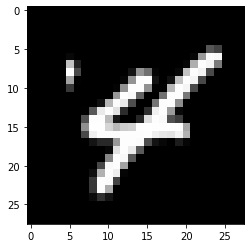

In [ ]:
plt.imshow(train_sample, cmap = plt.cm.gray)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NMF_AE(input_shape = 28, encoder_shape = 18).to(device)
X = train_sample.T.copy()

In [ ]:
loss_history = []
for epoch in range(epochs):
    # Shuffle data tại mỗi epoch
    rnd.shuffle(X)
    for i in range(X.shape[0]):
        batch_features = torch.from_numpy(X[i, :].reshape(28, 1))
        outputs = model(batch_features)
        train_loss = (outputs - batch_features).pow(2).sum()

        train_loss.backward()
        
        model.W_enc.data -= learning_rate * model.W_enc.grad.data
        model.W_dec.data = nn.functional.relu(model.W_dec.data - learning_rate * model.W_dec.grad.data)
        loss_history.append(train_loss.item())

        model.W_enc.grad.data.zero_()
        model.W_dec.grad.data.zero_()

In [ ]:
W = model.getDecoderMat()

In [ ]:
H = []
X = train_sample.T.copy()
for i in range(28):
    batch_features = torch.from_numpy(X[i, :].reshape(28, 1))
    col_H = model.compress(batch_features)
    H.append(col_H)
H = np.hstack(H)

In [ ]:
(W >= 0).all()

True

In [ ]:
(H >= 0).all()

True

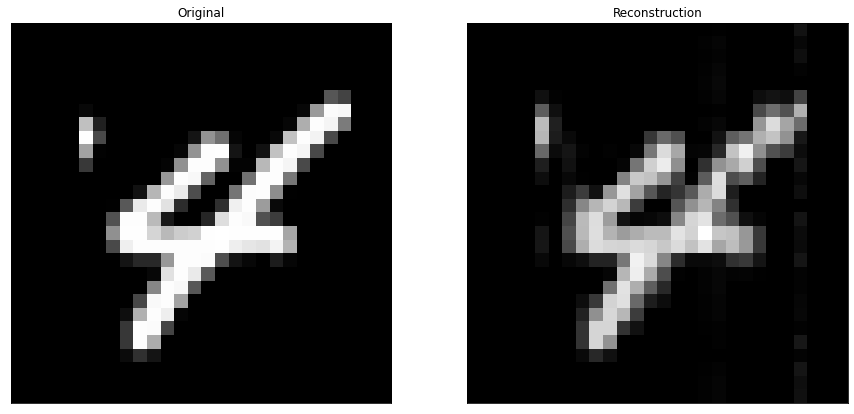

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 10))
axes[0].imshow(train_sample, cmap = plt.cm.gray)
axes[1].imshow(W @ H, cmap = plt.cm.gray)

axes[0].set(xticks = [], yticks = [], title = 'Original')
axes[1].set(xticks = [], yticks = [], title = 'Reconstruction')

fig.savefig('Demo_01.jpg')